# Basic plotting using rasterio and geopandas

First import some packages. We will use these to plot some rasters

In [1]:
import cartopy as cp
import cartopy.crs as ccrs
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

First, lets import some DEMs

In [2]:
DEMdata = rio.open('shillong_SRTM30_UTM.bil')

We can check on various aspects of the data using some built in `rasterio` functions

In [3]:
bounds = DEMdata.bounds

In [4]:
DEMdata.crs

CRS.from_epsg(32646)

In [5]:
type(bounds)

rasterio.coords.BoundingBox

Now we want to get the extent for mapping with `cartopy`. The data format is left, right, bottom, top (*WARNING*: this is a different order to the bounds in `rasterio`)

In [6]:
Extent = [bounds.left,bounds.right,bounds.bottom,bounds.top]

In [7]:
Extent

[325659.96215384, 421119.96215384, 2777112.16440704, 2835612.16440704]

We need to load the data an an array so we can later pass it to a `show` call.

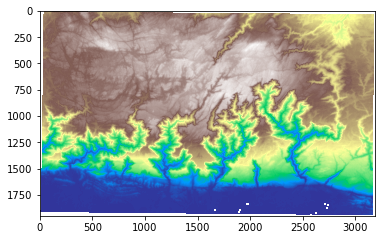

In [8]:
array = DEMdata.read(1)
array[array<-5]=np.nan
plt.imshow(array,cmap="terrain")

So far, so good. Now lets get the hillshade. I made this using `lsdtopotools`

In [9]:
DEMHSdata = rio.open('shillong_SRTM30_UTM_HS.bil')

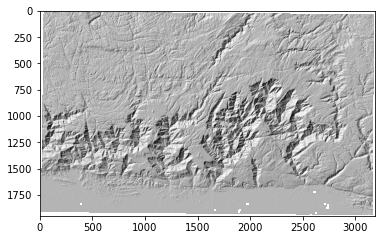

In [10]:
arrayHS = DEMHSdata.read(1)
arrayHS[arrayHS==-9999]=np.nan
plt.imshow(arrayHS,cmap="gray")

Okay, it is time to do some plotting with `cartopy`. Basically this just allows gridlines as well as (later) some interaction with `geopandas`

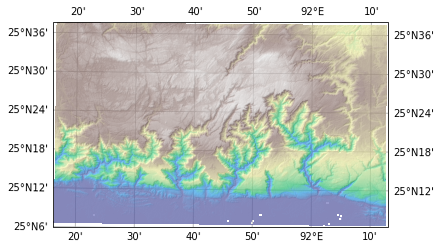

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(46))
# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(Extent, crs=ccrs.UTM(46))
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='terrain',alpha=0.5,zorder=2)
ax.imshow(arrayHS, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='gray',alpha=0.5,zorder=1)
fig.savefig("test.png", dpi=300)

# Lets try with some points

Okay, now lets import some data using `pandas` and `geopandas.

In [12]:
import pandas as pd
import geopandas as gpd

I made some csv data using `lsdtopotools`. We can load it into a dataframe.

In [13]:
df = pd.read_csv("shillong_SRTM30_UTM_chi_data_map.csv")

The csv file has latitude and longitude coordinates, so we can use these to register the geometry with a `geopandas` dataframe, and we can also set the coordinate reference system (`set_crs`). The `latitude` and `longitude` data produced by `lsdtopotools` is always in `epsg=4326`.

In [14]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
print(gdf.head())

    latitude  longitude     chi  elevation  flow_distance  drainage_area  \
0  25.520114  91.901374  11.611     1778.0       113110.0       905400.0   
1  25.519843  91.901377  11.580     1777.0       113080.0       912600.0   
2  25.519574  91.901678  11.535     1777.0       113040.0       942300.0   
3  25.519301  91.901382  11.491     1777.0       113000.0       950400.0   
4  25.519030  91.901384  11.461     1777.0       112970.0       952200.0   

   source_key  basin_key                   geometry  
0           0          0  POINT (91.90137 25.52011)  
1           0          0  POINT (91.90138 25.51984)  
2           0          0  POINT (91.90168 25.51957)  
3           0          0  POINT (91.90138 25.51930)  
4           0          0  POINT (91.90138 25.51903)  


So after some experimenting, it turns out that the plotting functions are not very happy if you don't keep everything in the same coordinate system. So I need to transform the geopandas dataframe to the correct UTM coordinate system. You will probably need to make sure your rasters and your dataframes are alyways in the same coordinate system.

In [15]:
gdf2 = gdf.to_crs("EPSG:32646")

Before we plot these, I want to make a scaling function that sets the marker size as a function of drainage area. But I need to scale the marker sizes. I use a scaling with the log (base 10) of the drainage area:

In [16]:
def log_value_scaler(vals, min_scale = 0.5, max_scale = 6):
    logvals = np.log10(vals)
    minval = np.min(logvals)
    maxval = np.max(logvals)
    newvals  = np.subtract(logvals,minval)
    newvals = np.divide(newvals,(maxval-minval))
    newvals = np.multiply(newvals,max_scale-min_scale)
    newvals = np.add(newvals,min_scale)
    return newvals

In [17]:
logv = log_value_scaler(gdf2.drainage_area)
gdf2["scaled_area"] = logv
print(gdf2.head())

    latitude  longitude     chi  elevation  flow_distance  drainage_area  \
0  25.520114  91.901374  11.611     1778.0       113110.0       905400.0   
1  25.519843  91.901377  11.580     1777.0       113080.0       912600.0   
2  25.519574  91.901678  11.535     1777.0       113040.0       942300.0   
3  25.519301  91.901382  11.491     1777.0       113000.0       950400.0   
4  25.519030  91.901384  11.461     1777.0       112970.0       952200.0   

   source_key  basin_key                        geometry  scaled_area  
0           0          0  POINT (389604.973 2822997.254)     0.504820  
1           0          0  POINT (389604.967 2822967.250)     0.511202  
2           0          0  POINT (389634.969 2822937.253)     0.537005  
3           0          0  POINT (389604.974 2822907.253)     0.543901  
4           0          0  POINT (389604.967 2822877.249)     0.545426  


Okay, we are ready to print the points on top of the maps. The colour is given by the chi coordinate and the marker size by the scaled drainage area.

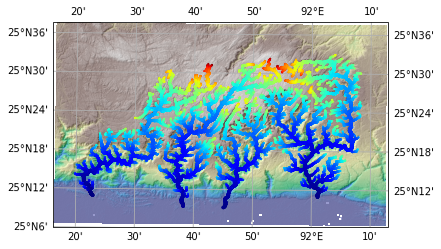

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(46))
# Limit the extent of the map to a small longitude/latitude range.
#ax.set_extent(Extent, crs=ccrs.UTM(46))
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='terrain',alpha=0.5,zorder=-2)
ax.imshow(arrayHS, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='gray',alpha=1,zorder=-3)
gdf2.plot(ax=ax, markersize=gdf2['scaled_area'], column='chi', zorder=10,cmap="jet")
fig.savefig("test.png", dpi=800)
fig.show()

## Selecting data

Lets just plot a single basin

In [19]:
gdf_b1 = gdf2[(gdf2['basin_key'] == 2)]
print(gdf_b1.head())

        latitude  longitude     chi  elevation  flow_distance  drainage_area  \
23963  25.538379  91.880905  11.571     1861.0        98821.0       942300.0   
23964  25.538106  91.880609  11.528     1861.0        98778.0       957600.0   
23965  25.537833  91.880313  11.484     1859.0        98736.0       968400.0   
23966  25.537559  91.880017  11.441     1859.0        98693.0       970200.0   
23967  25.537286  91.879721  11.398     1859.0        98651.0      1021500.0   

       source_key  basin_key                        geometry  scaled_area  
23963         330          2  POINT (387564.968 2825037.254)     0.537005  
23964         330          2  POINT (387534.972 2825007.248)     0.549982  
23965         330          2  POINT (387504.966 2824977.253)     0.559018  
23966         330          2  POINT (387474.969 2824947.246)     0.560514  
23967         330          2  POINT (387444.973 2824917.251)     0.602029  


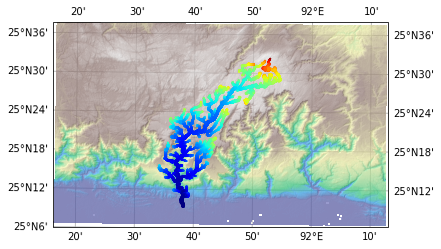

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(46))
# Limit the extent of the map to a small longitude/latitude range.
#ax.set_extent(Extent, crs=ccrs.UTM(46))
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='terrain',alpha=0.5,zorder=2)
ax.imshow(arrayHS, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='gray',alpha=0.5,zorder=1)
gdf_b1.plot(ax=ax, markersize=gdf2['scaled_area'], column='chi', zorder=10,cmap="jet")
fig.savefig("test.png", dpi=800)
fig.show()

Lets find the sources in this basin

In [21]:
these_sk = np.unique(gdf_b1["source_key"])
print(these_sk)

[330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459]


In [22]:
thinned_sk = these_sk[0::10]
print(thinned_sk)

[330 340 350 360 370 380 390 400 410 420 430 440 450]


You can select these using the `isin` syntax

In [23]:
gdf_sk1 = gdf_b1[(gdf_b1['source_key'].isin(thinned_sk))]
print(gdf_sk1.head())

        latitude  longitude     chi  elevation  flow_distance  drainage_area  \
23963  25.538379  91.880905  11.571     1861.0        98821.0       942300.0   
23964  25.538106  91.880609  11.528     1861.0        98778.0       957600.0   
23965  25.537833  91.880313  11.484     1859.0        98736.0       968400.0   
23966  25.537559  91.880017  11.441     1859.0        98693.0       970200.0   
23967  25.537286  91.879721  11.398     1859.0        98651.0      1021500.0   

       source_key  basin_key                        geometry  scaled_area  
23963         330          2  POINT (387564.968 2825037.254)     0.537005  
23964         330          2  POINT (387534.972 2825007.248)     0.549982  
23965         330          2  POINT (387504.966 2824977.253)     0.559018  
23966         330          2  POINT (387474.969 2824947.246)     0.560514  
23967         330          2  POINT (387444.973 2824917.251)     0.602029  


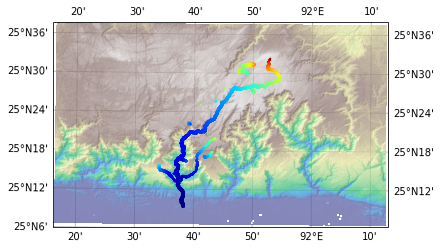

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(46))
# Limit the extent of the map to a small longitude/latitude range.
#ax.set_extent(Extent, crs=ccrs.UTM(46))
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#print('Projecting and plotting image (this may take a while)...')
ax.imshow(array, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='terrain',alpha=0.5,zorder=2)
ax.imshow(arrayHS, extent=Extent, transform=ccrs.UTM(46), origin="upper", cmap='gray',alpha=0.5,zorder=1)
gdf_sk1.plot(ax=ax, markersize=gdf2['scaled_area'], column='chi', zorder=10,cmap="jet")
#fig.savefig("test.png", dpi=500)
fig.show()

We can also do a simpler plot

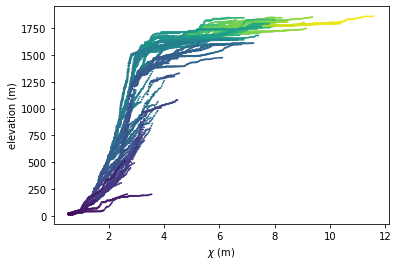

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(gdf_b1.chi,gdf_b1.elevation,c=gdf_b1.flow_distance,s=gdf_b1['scaled_area'])
plt.xlabel(r"$\chi$ (m)")
plt.ylabel("elevation (m)")
fig.show()

We could also plot more basins

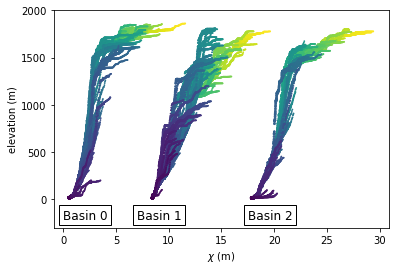

In [36]:
gdf_b2 = gdf2[(gdf2['basin_key'] == 0)]
gdf_b3 = gdf2[(gdf2['basin_key'] == 3)]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gdf_b1.chi,gdf_b1.elevation,c=gdf_b1.flow_distance,s=gdf_b1['scaled_area'])
ax.scatter(np.add(gdf_b2.chi,8),gdf_b2.elevation,c=gdf_b2.flow_distance,s=gdf_b2['scaled_area'])
ax.scatter(np.add(gdf_b3.chi,17.5),gdf_b3.elevation,c=gdf_b3.flow_distance,s=gdf_b3['scaled_area'])


plt.text(0, -100, "Basin 0", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )

plt.text(7, -100, "Basin 1", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )

plt.text(17.5, -100, "Basin 2", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )


plt.xlabel(r"$\chi$ (m)")
plt.ylabel("elevation (m)")
ax.set_ylim(-300,2000)
fig.show()

Actually, I want to thin the data to get rid of the small tributaries. 

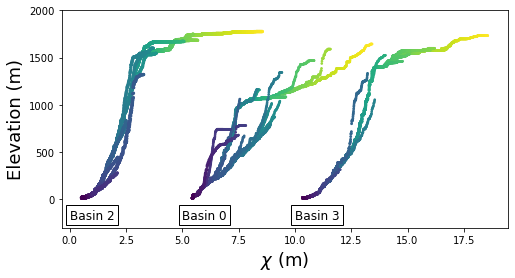

In [47]:
gdf_b1 = gdf2[(gdf2['basin_key'] == 2) & (gdf2['scaled_area'] > 2.5)] 
gdf_b2 = gdf2[(gdf2['basin_key'] == 0) & (gdf2['scaled_area'] > 2.5)]
gdf_b3 = gdf2[(gdf2['basin_key'] == 3) & (gdf2['scaled_area'] > 2.5)]


fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(gdf_b1.chi,gdf_b1.elevation,c=gdf_b1.flow_distance,s=np.multiply(gdf_b1['scaled_area'],2))
ax.scatter(np.add(gdf_b2.chi,5),gdf_b2.elevation,c=gdf_b2.flow_distance,s=gdf_b2['scaled_area'])
ax.scatter(np.add(gdf_b3.chi,10),gdf_b3.elevation,c=gdf_b3.flow_distance,s=gdf_b3['scaled_area'])


plt.text(0, -100, "Basin 2", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )

plt.text(5, -100, "Basin 0", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )

plt.text(10, -100, "Basin 3", size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )


plt.xlabel(r"$\chi$ (m)",size=18)
plt.ylabel("Elevation (m)",size=18)
ax.set_ylim(-300,2000)
fig.show()